[2015-08-27] OSQP failed: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information. — trying ECOS
[2015-08-27] ECOS failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver' — trying SCS
[2015-08-27] All solvers failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver'
[2015-08-31] OSQP failed: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information. — trying ECOS
[2015-08-31] ECOS failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver' — trying SCS
[2015-08-31] All solvers failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver'
[2015-10-01] OSQP failed: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information. — trying ECOS
[2015-10-01] ECOS failed: EfficientFrontier.max_sharpe() got an unexpected keyword argument 'solver' — trying SCS
[2015-10-01] All solvers failed: EfficientFrontie

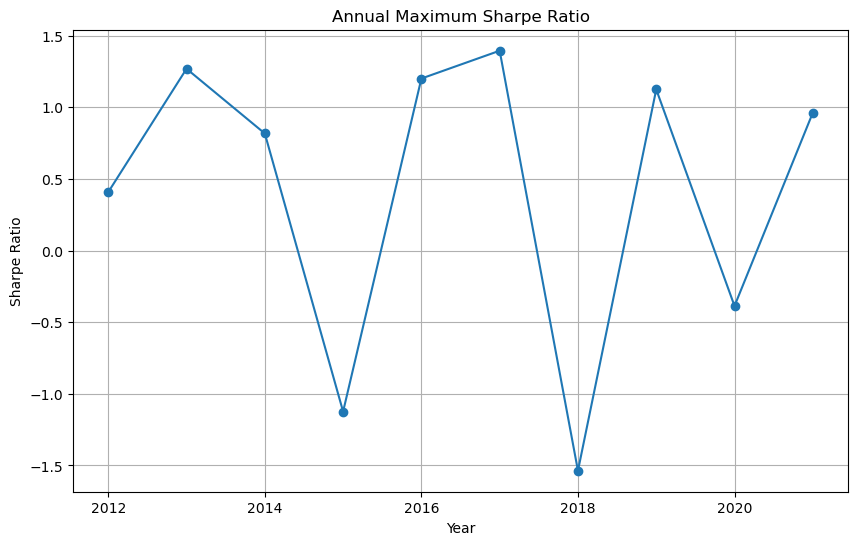

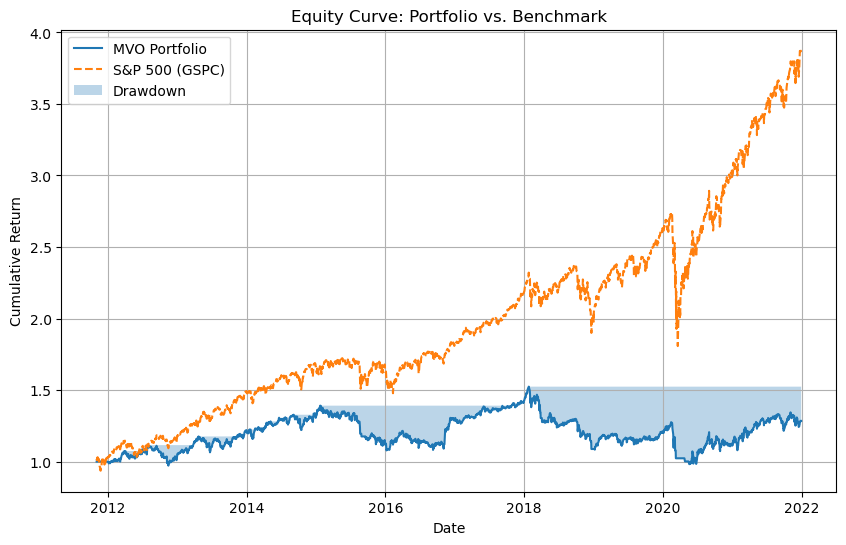

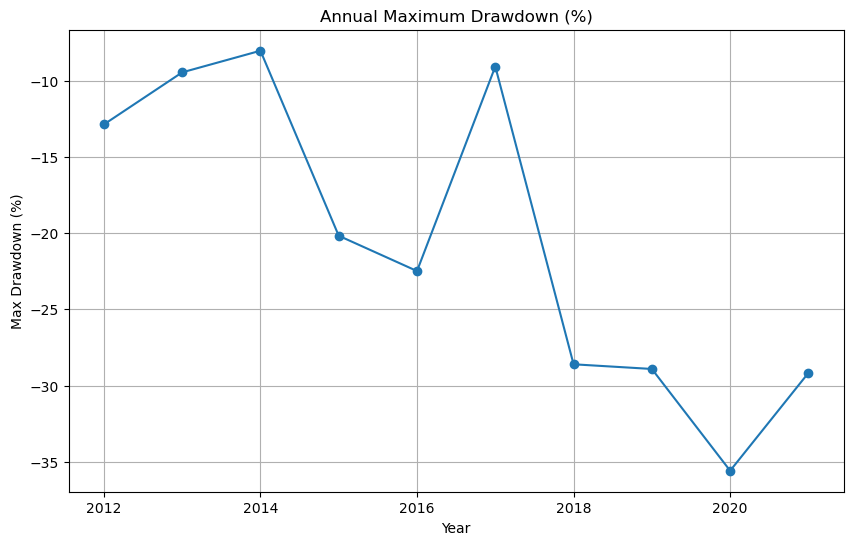

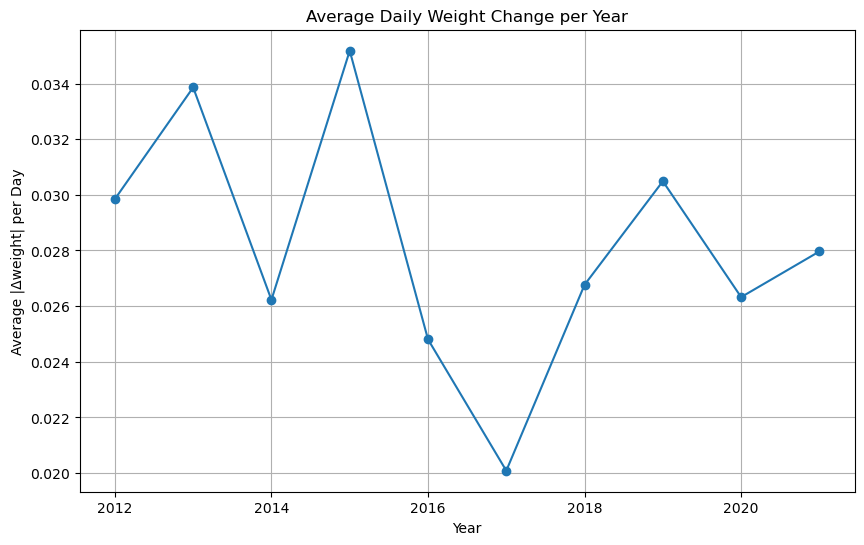


=== Portfolio Performance ===
Total Return:        28.40%
CAGR:                2.50%
Annual Volatility:   13.68%
Sharpe Ratio:        0.18
Max Drawdown:        -35.58%

=== S&P 500 Benchmark ===
Total Return:        286.04%
CAGR:                14.26%
Annual Volatility:   16.52%
Sharpe Ratio:        0.86
Max Drawdown:        -33.92%


In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, expected_returns, risk_models

# =========================
# 1. Configuration
# =========================
DATA_PATH    = "/Users/benjaminli/Code/MyTradingProjects/DRL_Portfolio_Optimisation/DRL-Portfolio-Optimisation/data"

# Official backtest period start/end (results recorded from RESULT_START_DATE)
RESULT_START_DATE = "2012-01-01"
END_DATE          = "2021-12-31"
LOOKBACK          = 60   # Rolling window length (days)

# Compute data loading start to include LOOKBACK days prior to RESULT_START_DATE
LOAD_START_DATE = (pd.to_datetime(RESULT_START_DATE) - pd.Timedelta(days=LOOKBACK)).strftime('%Y-%m-%d')

# Sector ETFs (or proxies) and benchmark
SECTOR_ETFS = [
    'SP500-50', 'SP500-25', 'SP500-30', 'SP500-40',
    'SP500-35', 'SP500-20', 'SP500-45', 'SP500-15',
    'SP500-60', 'SP500-55', 'GSPE'
]
BENCHMARK = "GSPC"  # S&P 500 Index

WEIGHT_BOUNDS  = (0, 1)  # Long-only
RISK_FREE_RATE = 0      # For Sharpe calculation

warnings.filterwarnings("ignore")  # suppress pypfopt warnings

# =========================
# 2. Load Price Data (with extended lookback)
# =========================
tickers = SECTOR_ETFS + [BENCHMARK]
prices = pd.DataFrame()


for t in tickers:
    path = os.path.join(DATA_PATH, f"{t}.csv")
    df = pd.read_csv(path, index_col="Date", parse_dates=True)
    prices[t] = df["Adj Close"]

prices.ffill(inplace=True)
prices.dropna(how="all", inplace=True)

# Restrict to loaded date range and ensure numeric
prices = prices.loc[LOAD_START_DATE:END_DATE].apply(pd.to_numeric, errors="coerce")

# Separate SPY and sector prices
spy_prices    = prices[BENCHMARK].copy()
sector_prices = prices[SECTOR_ETFS].copy()

# =========================
# 3. Helper: Positive Definite Covariance
# =========================
def make_positive_definite(cov, epsilon=1e-4):
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvals = np.clip(eigvals, epsilon, None)
    pd_cov = eigvecs @ np.diag(eigvals) @ eigvecs.T
    return (pd_cov + pd_cov.T) / 2

# =========================
# 4. Rolling Optimization
# =========================
daily_weights = {}
daily_sharpe  = {}

for today in sector_prices.index:
    # Only record results from the official backtest period
    if today < pd.to_datetime(RESULT_START_DATE):
        continue

    window = sector_prices.loc[:today].iloc[-LOOKBACK:]
    if window.isnull().any().any() or (window < 0).any().any():
        continue


    # 1) Estimate returns and covariance
    mu      = expected_returns.mean_historical_return(window)
    raw_cov = risk_models.CovarianceShrinkage(window).ledoit_wolf()
    cov     = make_positive_definite(raw_cov)

    # 2) Initialize optimizer
    ef = EfficientFrontier(mu, cov, weight_bounds=WEIGHT_BOUNDS)

    # 3) If no asset beats the risk-free rate, hold cash (zero weights)
    if (mu <= RISK_FREE_RATE).all():
        weights = {ticker: 0.0 for ticker in window.columns}
        ret, vol, sr = 0.0, 0.0, 0.0

    else:
        try:
            ef.max_sharpe(risk_free_rate=RISK_FREE_RATE)
        except Exception as e:
            print(f"[{today.date()}] OSQP failed: {e} — trying ECOS")
            try:
                ef.max_sharpe(risk_free_rate=RISK_FREE_RATE, solver="ECOS")
            except Exception as e2:
                print(f"[{today.date()}] ECOS failed: {e2} — trying SCS")
                try:
                    ef.max_sharpe(risk_free_rate=RISK_FREE_RATE, solver="SCS")
                except Exception as e3:
                    print(f"[{today.date()}] All solvers failed: {e3}")
                    weights = {ticker: 0.0 for ticker in window.columns}
                    ret, vol, sr = 0.0, 0.0, 0.0
                    continue  # skip to next date

        weights = ef.clean_weights()
        ret, vol, sr = ef.portfolio_performance(verbose=False)

    # 4) Save results
    daily_weights[today] = pd.Series(weights)
    daily_sharpe[today]  = sr


# Build DataFrame/Series and fill any gaps
weights_df = pd.DataFrame(daily_weights).T.sort_index()
sharpe_sr  = pd.Series(daily_sharpe).sort_index().ffill().bfill()

# =========================
# 5. Portfolio Return Simulation
# =========================
# Next-day returns
asset_rets = sector_prices.pct_change().shift(-1)
# Weighted sum
port_rets  = (weights_df * asset_rets).sum(axis=1).dropna()

# =========================
# 6. Annual Metrics
# =========================
annual_rets  = port_rets.resample("Y").apply(lambda r: (1 + r).prod() - 1)
annual_vols  = port_rets.resample("Y").std() * np.sqrt(252)
annual_srs   = annual_rets / annual_vols

# =========================
# 7. Overall Portfolio Performance
# =========================
cum_pnl       = (1 + port_rets).cumprod()
total_return  = cum_pnl.iloc[-1] - 1
days          = port_rets.shape[0]
cagr          = cum_pnl.iloc[-1] ** (252 / days) - 1
ann_vol       = port_rets.std() * np.sqrt(252)
ann_sharpe    = cagr / ann_vol
running_max   = cum_pnl.cummax()
drawdown      = (cum_pnl - running_max) / running_max
max_drawdown = drawdown.resample("YE").min()


# Average daily weight change per year
daily_weight_change = weights_df.diff().abs().mean(axis=1)
avg_weight_change_yr = daily_weight_change.resample("YE").mean()


# =========================
# 8. Benchmark (SPX) Metrics
# =========================
spy_aligned = spy_prices.reindex(port_rets.index).ffill()
spy_rets    = spy_aligned.pct_change().shift(-1).dropna()
spy_cum     = (1 + spy_rets).cumprod()

spy_tot_ret = spy_cum.iloc[-1] - 1
spy_cagr    = spy_cum.iloc[-1] ** (252 / spy_rets.shape[0]) - 1
spy_ann_vol = spy_rets.std() * np.sqrt(252)
spy_sharpe  = spy_cagr / spy_ann_vol
spy_dd      = (spy_cum - spy_cum.cummax()) / spy_cum.cummax()
spy_max_dd  = spy_dd.min()

# =========================
# 9. Visualization
# =========================
plt.figure(figsize=(10, 6))
plt.plot(annual_srs.index.year, annual_srs.values, marker="o")
plt.title("Annual Maximum Sharpe Ratio")
plt.xlabel("Year")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cum_pnl, label="MVO Portfolio")
plt.plot(spy_cum, "--", label="S&P 500 (GSPC)")
plt.fill_between(drawdown.index, cum_pnl, running_max,
                 where=drawdown < 0, alpha=0.3, label="Drawdown")
plt.title("Equity Curve: Portfolio vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

# New: Maximum drawdown per year
# Filter out 2011 data from max_drawdown
max_drawdown_filtered = max_drawdown[max_drawdown.index.year != 2011]

# Plot the filtered maximum drawdown
plt.figure(figsize=(10, 6))
plt.plot(max_drawdown_filtered.index.year, max_drawdown_filtered.values * 100, marker="o")
plt.title("Annual Maximum Drawdown (%)")
plt.xlabel("Year")
plt.ylabel("Max Drawdown (%)")
plt.grid(True)
plt.show()

# New: Average daily change in weights per year
plt.figure(figsize=(10, 6))
plt.plot(avg_weight_change_yr.index.year, avg_weight_change_yr.values, marker="o")
plt.title("Average Daily Weight Change per Year")
plt.xlabel("Year")
plt.ylabel("Average |Δweight| per Day")
plt.grid(True)
plt.show()

# =========================
# 10. Summary Output
# =========================
print("\n=== Portfolio Performance ===")
print(f"Total Return:        {total_return:.2%}")
print(f"CAGR:                {cagr:.2%}")
print(f"Annual Volatility:   {ann_vol:.2%}")
print(f"Sharpe Ratio:        {ann_sharpe:.2f}")
print(f"Max Drawdown:        {drawdown.min():.2%}")

print("\n=== S&P 500 Benchmark ===")
print(f"Total Return:        {spy_tot_ret:.2%}")
print(f"CAGR:                {spy_cagr:.2%}")
print(f"Annual Volatility:   {spy_ann_vol:.2%}")
print(f"Sharpe Ratio:        {spy_sharpe:.2f}")
print(f"Max Drawdown:        {spy_cum.sub(spy_cum.cummax()).div(spy_cum.cummax()).min():.2%}")
